In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from sklearn.cluster import KMeans
from datetime import datetime
import uuid

In [14]:
df = pd.read_parquet('processed_orders.parquet')
df_before = pd.read_parquet('processed_df_before_orders.parquet')
df_after = pd.read_parquet('processed_df_after_orders.parquet')

In [15]:
# Когортный анализ
df['InvoiceMonth'] = df['Дата'].dt.to_period('M')
df['CohortMonth'] = df.groupby('Код клиента')['Дата'].transform('min').dt.to_period('M')

# Расчет "Cohort Index" - количество месяцев с момента первой покупки
# Это поможет нам увидеть, сколько месяцев клиент остается активным
def get_month_difference(dataframe, column):
    year = dataframe[column].dt.year
    month = dataframe[column].dt.month
    return year * 12 + month

df['MonthDifference'] = get_month_difference(df, 'InvoiceMonth') - get_month_difference(df, 'CohortMonth')

# Подсчет уникальных клиентов по когортам и месяцам с момента первой покупки
cohort_counts = df.groupby(['CohortMonth', 'MonthDifference'])['Код клиента'].nunique().reset_index()

# Создание сводной таблицы для когортного анализа
cohort_pivot = cohort_counts.pivot_table(index='CohortMonth',
                                         columns='MonthDifference',
                                         values='Код клиента')

# Расчет процента удержания
# Делим каждую строку на количество клиентов в "нулевом" месяце (т.е. на изначальный размер когорты)
cohort_sizes = cohort_pivot.iloc[:, 0]
retention_matrix = cohort_pivot.divide(cohort_sizes, axis=0)

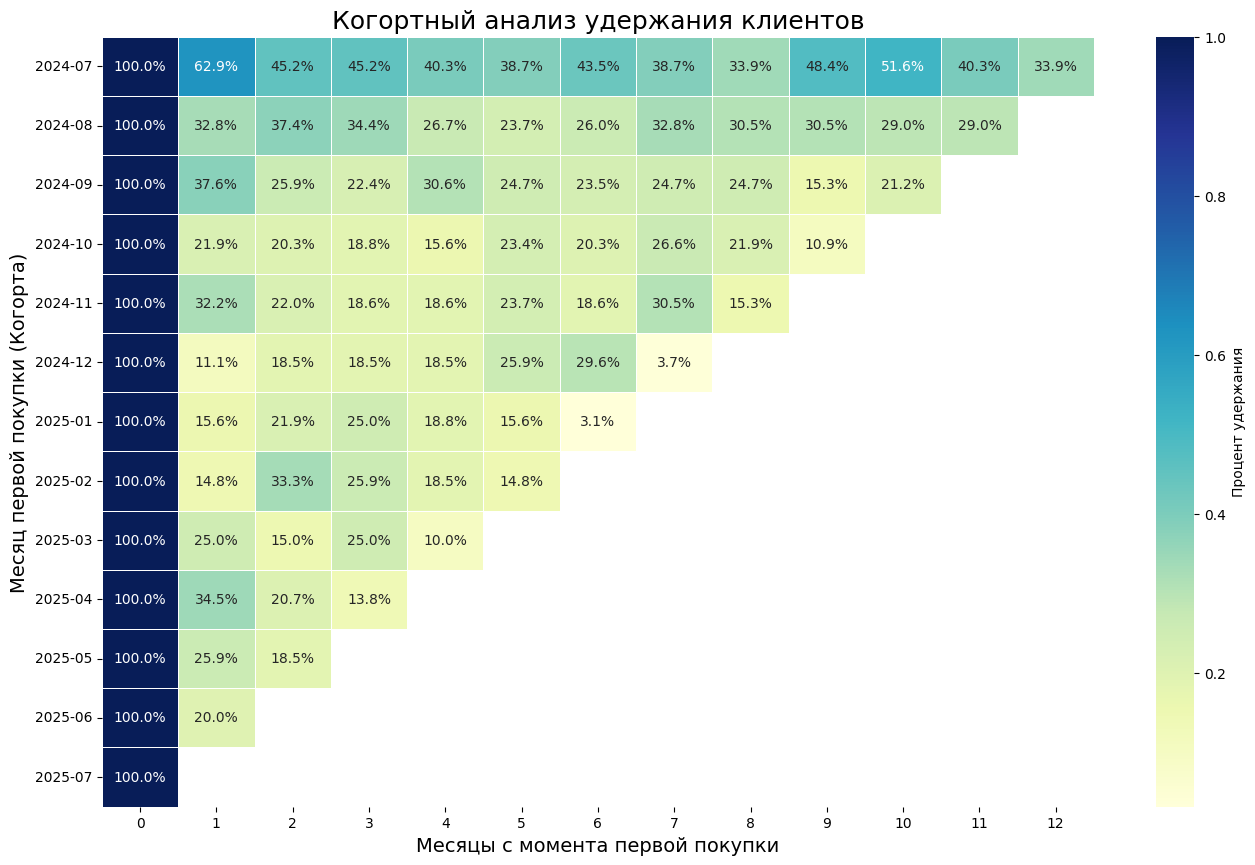

In [16]:
plt.figure(figsize=(16, 10))
sns.heatmap(retention_matrix,
            annot=True,    # Показывать значения на тепловой карте
            fmt='.1%',     # Форматировать значения как проценты с одним знаком после запятой
            cmap='YlGnBu', # Цветовая схема
            linewidths=.5, # Разделительные линии между ячейками
            cbar_kws={'label': 'Процент удержания'}) # Подпись для цветовой шкалы

plt.title('Когортный анализ удержания клиентов', fontsize=18)
plt.xlabel('Месяцы с момента первой покупки', fontsize=14)
plt.ylabel('Месяц первой покупки (Когорта)', fontsize=14)
plt.yticks(rotation=0) # Горизонтальное расположение меток по оси Y
plt.show()

In [17]:
cohort_counts.to_csv('/home/roman/PycharmProjects/Dzemidovich_kursovoi/results/cohort_counts.csv')

In [18]:
# Прогноз прибыли с Prophet для всех данных
prophet_data = df.groupby(df['Дата'].dt.date)['Profit'].sum().reset_index()
prophet_data.columns = ['ds', 'y']
model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True)
model.fit(prophet_data)
future = model.make_future_dataframe(periods=365)
forecast = model.predict(future)

14:35:33 - cmdstanpy - INFO - Chain [1] start processing
14:35:33 - cmdstanpy - INFO - Chain [1] done processing


In [30]:
# Прогноз прибыли с Prophet на данных до фикс наценки
prophet_data_before = df_before.groupby(df_before['Дата'].dt.date)['Profit'].sum().reset_index()
prophet_data_before.columns = ['ds', 'y']
model_before = Prophet(yearly_seasonality=False, weekly_seasonality=True, daily_seasonality=True, seasonality_prior_scale=1.0)
model_before.fit(prophet_data_before)
future_before = model_before.make_future_dataframe(periods=200)
forecast_before = model_before.predict(future_before)

14:50:20 - cmdstanpy - INFO - Chain [1] start processing
14:50:20 - cmdstanpy - INFO - Chain [1] done processing


In [36]:
# Прогноз прибыли с Prophet на данных после фикс наценки
prophet_data_after = df_after.groupby(df_after['Дата'].dt.date)['Profit'].sum().reset_index()
prophet_data_after.columns = ['ds', 'y']
model_after = Prophet(yearly_seasonality=False, weekly_seasonality=True, daily_seasonality=True, seasonality_prior_scale=1.0)
model_after.fit(prophet_data_after)
future_after = model_after.make_future_dataframe(periods=100)
forecast_after = model_after.predict(future_after)

15:01:48 - cmdstanpy - INFO - Chain [1] start processing
15:01:49 - cmdstanpy - INFO - Chain [1] done processing


In [38]:
forecast.to_csv('/home/roman/PycharmProjects/Dzemidovich_kursovoi/results/profit_forecast.csv', index=False)

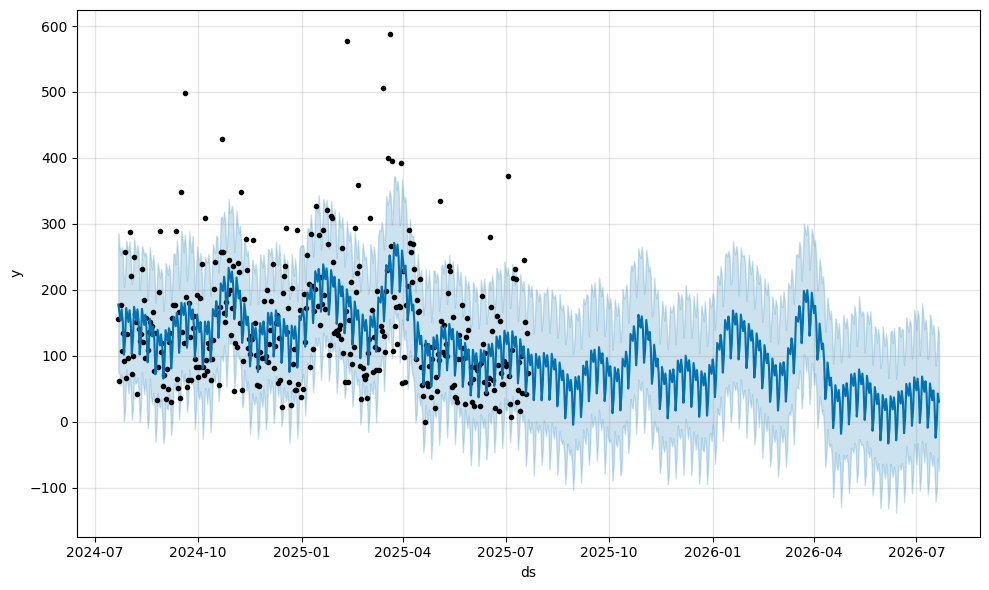

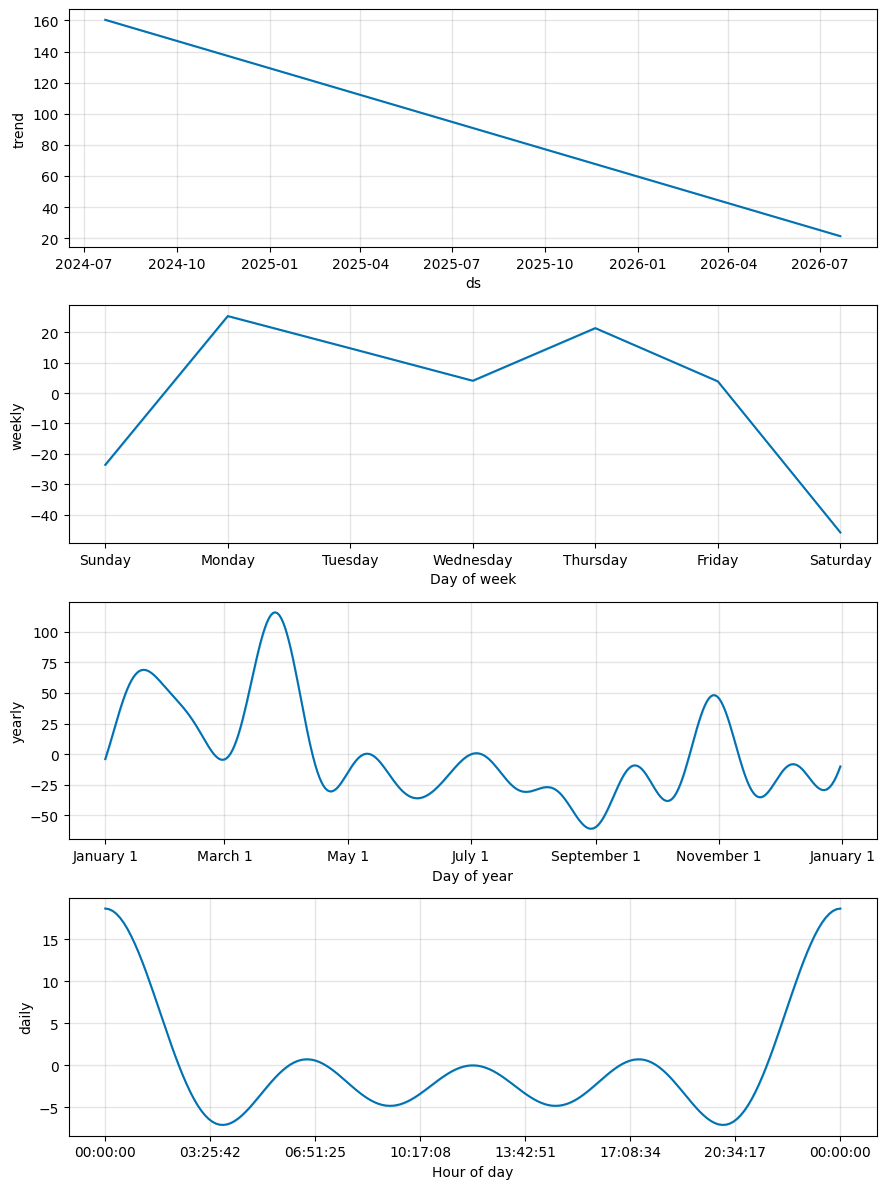

In [20]:
# Прогноз на всех данных
fig1 = model.plot(forecast)
fig2 = model.plot_components(forecast)

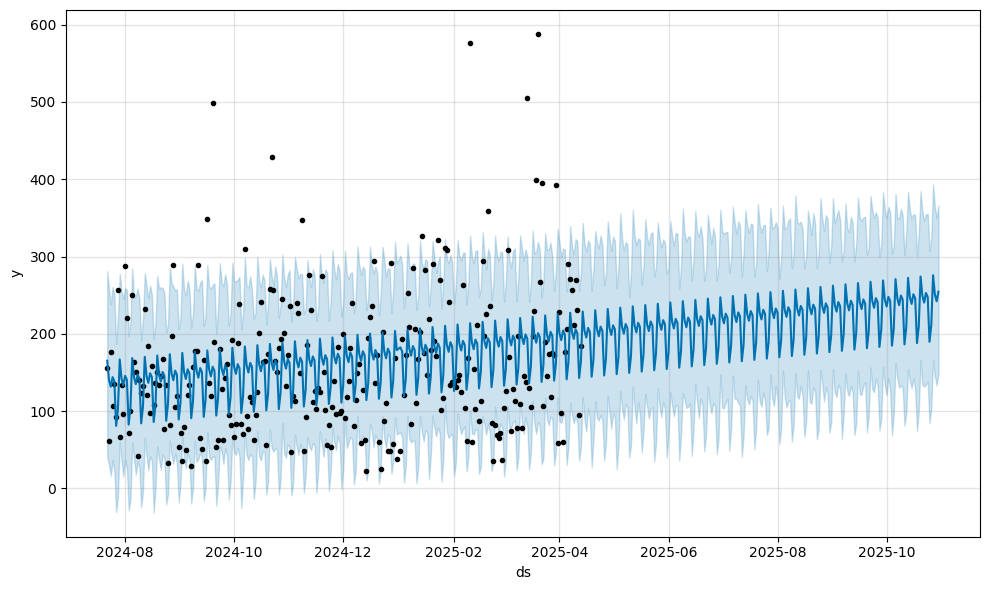

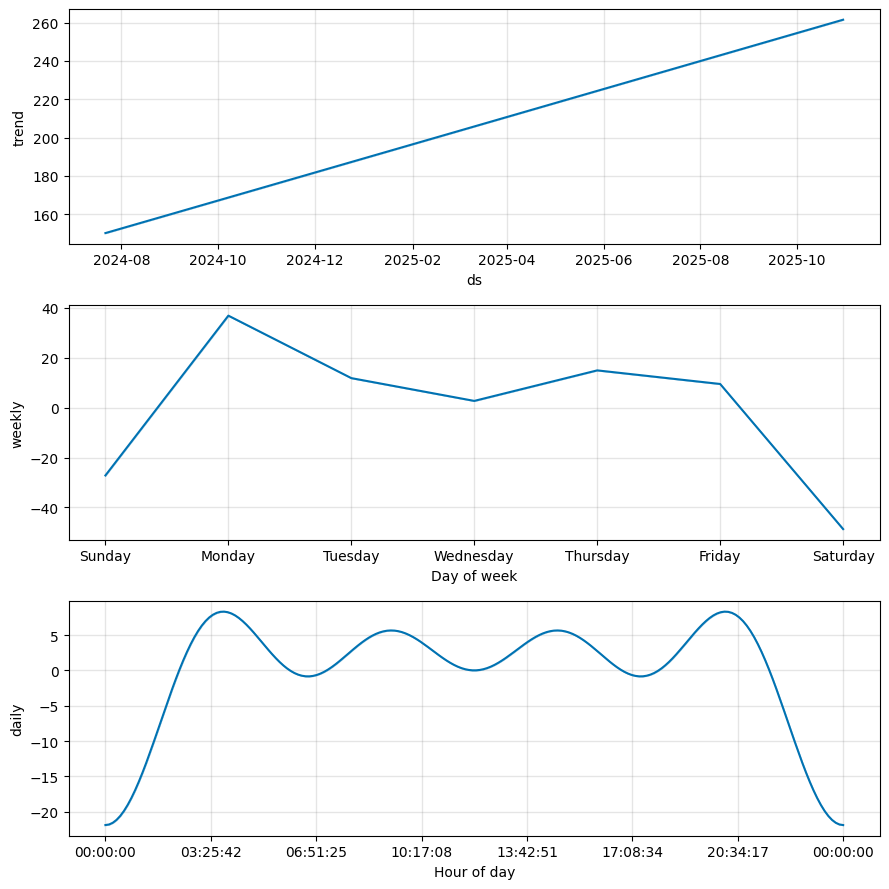

In [37]:
# Прогноз на данных до наценки
fig1 = model_before.plot(forecast_before)
fig2 = model_before.plot_components(forecast_before)

In [32]:
forecast_before

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2024-07-22,150.223010,40.413280,280.965748,150.223010,150.223010,15.026108,15.026108,15.026108,-21.874973,-21.874973,-21.874973,36.901081,36.901081,36.901081,0.0,0.0,0.0,165.249119
1,2024-07-23,150.461814,29.741054,258.336244,150.461814,150.461814,-10.029950,-10.029950,-10.029950,-21.874973,-21.874973,-21.874973,11.845023,11.845023,11.845023,0.0,0.0,0.0,140.431865
2,2024-07-24,150.700619,16.317653,238.261015,150.700619,150.700619,-19.171184,-19.171184,-19.171184,-21.874973,-21.874973,-21.874973,2.703789,2.703789,2.703789,0.0,0.0,0.0,131.529435
3,2024-07-25,150.939423,36.596748,260.523327,150.939423,150.939423,-6.926228,-6.926228,-6.926228,-21.874973,-21.874973,-21.874973,14.948745,14.948745,14.948745,0.0,0.0,0.0,144.013195
4,2024-07-26,151.178227,22.643638,250.201034,151.178227,151.178227,-12.379873,-12.379873,-12.379873,-21.874973,-21.874973,-21.874973,9.495099,9.495099,9.495099,0.0,0.0,0.0,138.798353
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
460,2025-10-26,260.503899,104.943403,324.895782,260.483155,260.523049,-49.070449,-49.070449,-49.070449,-21.874973,-21.874973,-21.874973,-27.195476,-27.195476,-27.195476,0.0,0.0,0.0,211.433450
461,2025-10-27,260.743264,165.630556,393.177967,260.722418,260.762557,15.026108,15.026108,15.026108,-21.874973,-21.874973,-21.874973,36.901081,36.901081,36.901081,0.0,0.0,0.0,275.769373
462,2025-10-28,260.982630,144.474168,364.742323,260.961666,261.002046,-10.029950,-10.029950,-10.029950,-21.874973,-21.874973,-21.874973,11.845023,11.845023,11.845023,0.0,0.0,0.0,250.952680
463,2025-10-29,261.221996,133.251610,349.457306,261.200878,261.241554,-19.171184,-19.171184,-19.171184,-21.874973,-21.874973,-21.874973,2.703789,2.703789,2.703789,0.0,0.0,0.0,242.050812


In [25]:
forecast_before.to_csv('/home/roman/PycharmProjects/Dzemidovich_kursovoi/results/profit_forecast_before.csv', index=False)

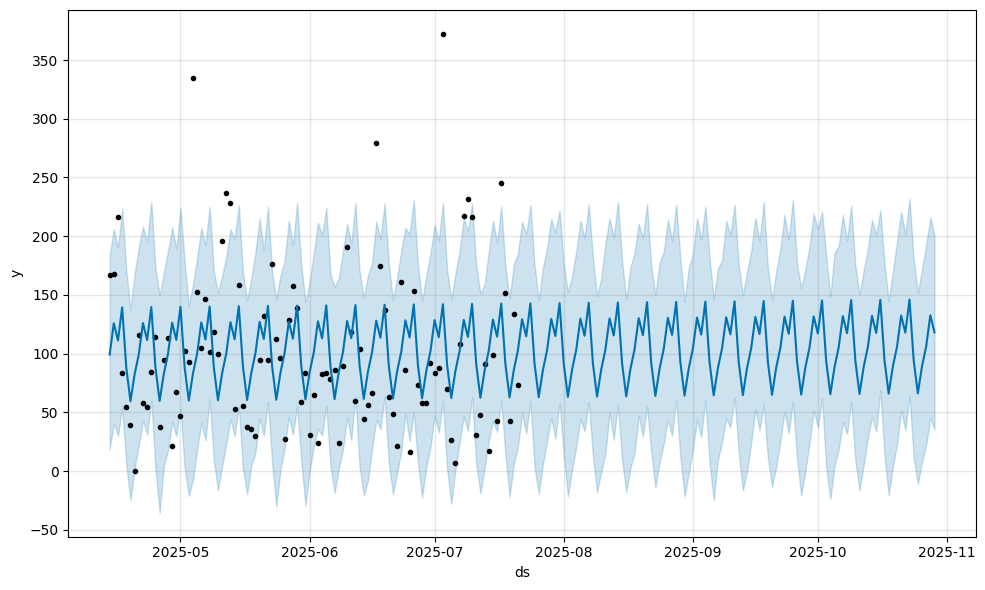

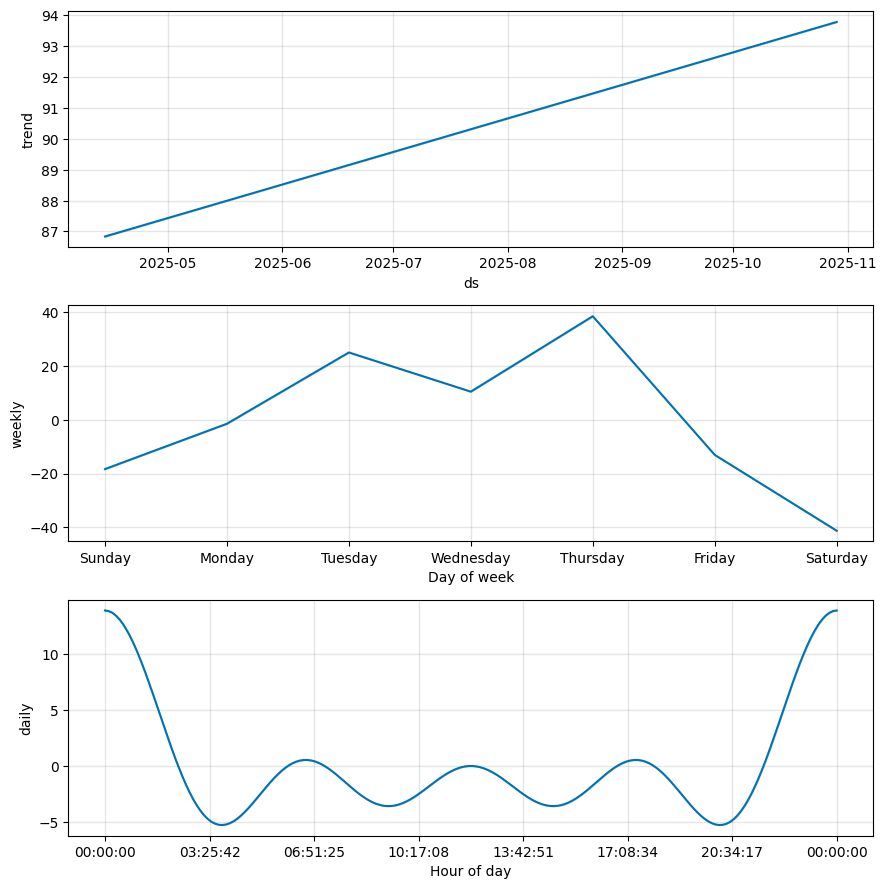

In [38]:
# Прогноз на данных до наценки
fig1 = model_after.plot(forecast_after)
fig2 = model_after.plot_components(forecast_after)